# 01 — YOLOv8 Training
## Heavy Vehicle Detection During Peak-Hour Ban Periods

**Module:** MAICEN 1125 · M4 · U3 · FMP Group Assignment

This notebook covers:
- Environment setup & GPU check
- Dataset download from GitHub (no API key required)
- YOLOv8n model training (50 epochs full / 5 epochs verify)
- Training metrics + curves
- Saving best weights

> ▶ **Runtime → Change runtime type → T4 GPU** before running.

After training, move to **`02_Inference.ipynb`** for validation + new-image predictions.

---

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Fri Feb 27 02:14:41 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **1 # Install Dependencies & Check GPU**

In [2]:
!pip install ultralytics --quiet

import torch
import ultralytics
from ultralytics import YOLO

print(f"Ultralytics : {ultralytics.__version__}")
print(f"PyTorch     : {torch.__version__}")
print(f"CUDA        : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU         : {torch.cuda.get_device_name(0)}")

# Save pip freeze snippet for reproducibility
!pip freeze | grep -E 'ultralytics|torch' > /content/pip_freeze_snippet.txt
print("\npip freeze snippet → /content/pip_freeze_snippet.txt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics : 8.4.18
PyTorch     : 2.10.0+cu128
CUDA        : True
GPU         : Tesla T4

pip freeze snippet → /content/pip_freeze_snippet.txt


# **2 # Configuration**

In [3]:
# ─── CONFIGURATION ────────────────────────────────────────────────────────────
VERIFY_ONLY   = False          # True = 5-epoch quick check; False = full 50-epoch run
MODEL_VARIANT = 'yolov8n.pt'  # yolov8n (nano) | yolov8s (small)
EPOCHS        = 5 if VERIFY_ONLY else 50
BATCH         = 16
IMGSZ         = 640
PROJECT_NAME  = 'heavy_vehicle_detection'
RUN_NAME      = f'yolov8n_{EPOCHS}ep'

# GitHub repository
GITHUB_REPO   = "https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods.git"
REPO_NAME     = "Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods"
DATASET_DIR   = f"/content/{REPO_NAME}/images dataset"

print(f"Mode      : {'VERIFY (5 ep)' if VERIFY_ONLY else 'FULL TRAINING (50 ep)'}")
print(f"Model     : {MODEL_VARIANT}")
print(f"Epochs    : {EPOCHS} | Batch: {BATCH} | Img: {IMGSZ}px")

Mode      : FULL TRAINING (50 ep)
Model     : yolov8n.pt
Epochs    : 50 | Batch: 16 | Img: 640px


# **3 # Download & Clone Dataset from Github**

In [4]:
import os
import yaml

# Clone the repository (skip if already cloned)
if not os.path.exists(f"/content/{REPO_NAME}"):
    print("Cloning repository...")
    !git clone --depth 1 "{GITHUB_REPO}" "/content/{REPO_NAME}"
else:
    print("Repository already cloned — pulling latest...")
    !git -C "/content/{REPO_NAME}" pull

print(f"\nDataset folder: {DATASET_DIR}")
print("Contents:", os.listdir(DATASET_DIR))

# ── Locate or create data.yaml ──────────────────────────────────────────────
DATA_YAML = os.path.join(DATASET_DIR, "data.yaml")

if not os.path.exists(DATA_YAML):
    print("data.yaml not found — generating from folder structure...")
    yaml_content = {
        "train": os.path.join(DATASET_DIR, "train", "images"),
        "val":   os.path.join(DATASET_DIR, "valid", "images"),
        "test":  os.path.join(DATASET_DIR, "test",  "images"),
        "nc":    3,
        "names": ["bus", "car", "truck"]
    }
    with open(DATA_YAML, "w") as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    print(f"data.yaml created at: {DATA_YAML}")
else:
    print(f"data.yaml found at: {DATA_YAML}")

# Confirm classes
with open(DATA_YAML) as f:
    cfg = yaml.safe_load(f)
print(f"Classes ({cfg['nc']}): {cfg['names']}")

Cloning repository...
Cloning into '/content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods'...
remote: Enumerating objects: 906, done.
remote: Counting objects: 100% (906/906), done.
remote: Compressing objects: 100% (745/745), done.
remote: Total 906 (delta 3), reused 901 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (906/906), 34.20 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (3/3), done.

Dataset folder: /content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/images dataset
Contents: ['test', 'README.roboflow.txt', 'data.yaml', 'valid', 'train']
data.yaml found at: /content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/images dataset/data.yaml
Classes (5): ['Car', 'Trucks', 'bus', 'car', 'truck']


# **4 # Explore the dataset structure**


Examine the `data.yaml` file to understand the dataset configuration, including classes and data paths.


In [5]:
import os

data_yaml_path = DATA_YAML
!cat "{data_yaml_path}"

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 5
names: ['Car', 'Trucks', 'bus', 'car', 'truck']

roboflow:
  workspace: salem-w0yva
  project: automatic-detection-of-heavy-vehicles-and-trailers-during-peak-hour-ban-periods
  version: 1
  license: CC BY 4.0
  url: https://app.roboflow.com/salem-w0yva/automatic-detection-of-heavy-vehicles-and-trailers-during-peak-hour-ban-periods/1

# **5 # Visualise a Few Training Samples (Sanity Check)**

train: 307 images
valid: 87 images
test : 45 images

Training label distribution:
  Car     : 763 instances
  Trucks  : 111 instances
  bus     : 78 instances
  car     : 827 instances
  truck   : 90 instances


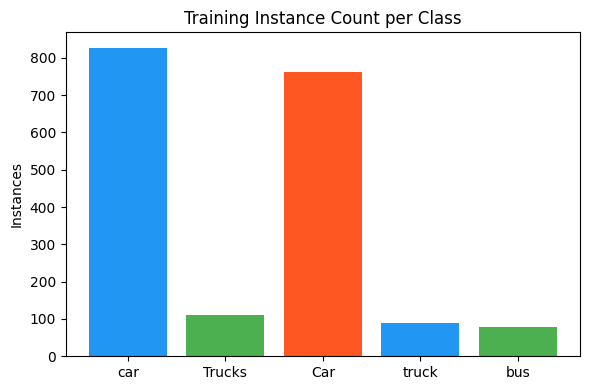

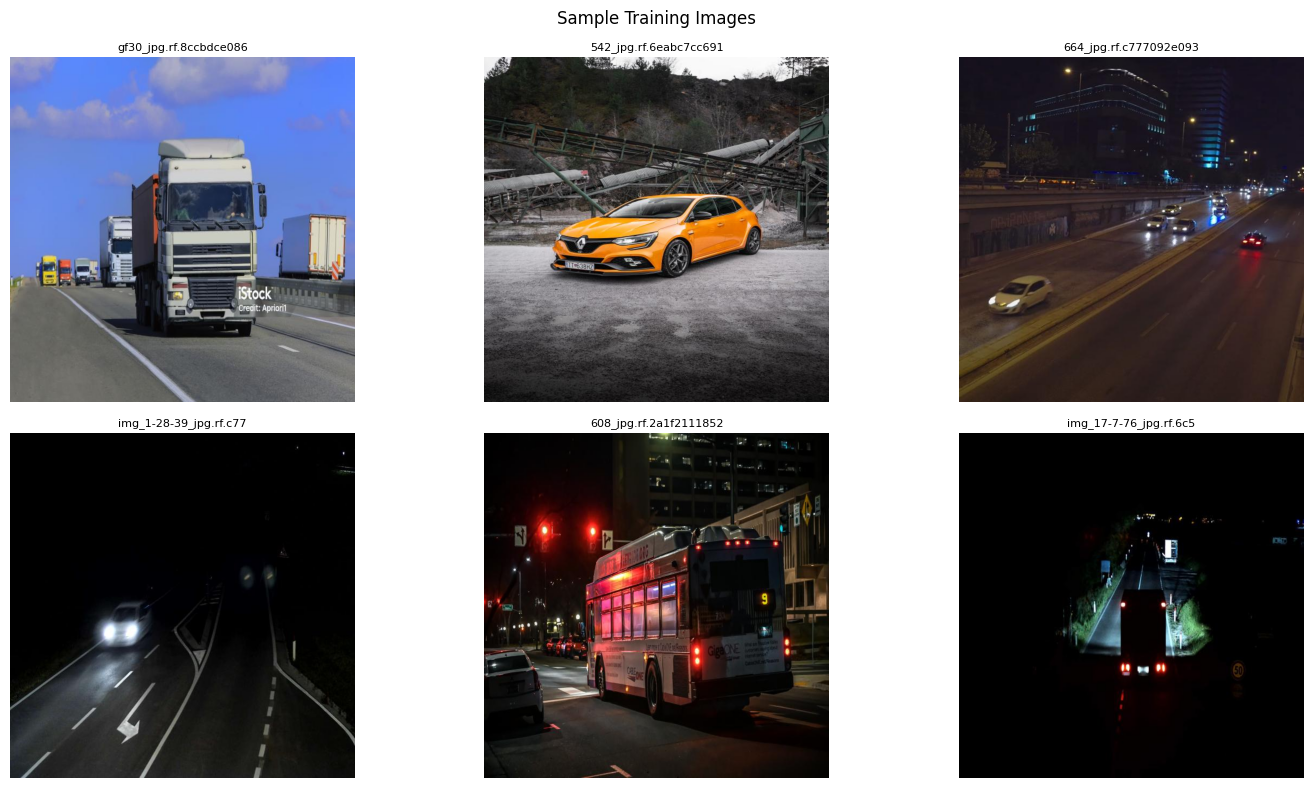

In [6]:
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

# Count images per split
for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(DATASET_DIR, split, 'images')
    if os.path.isdir(img_dir):
        n = len(os.listdir(img_dir))
        print(f"{split:5s}: {n} images")
    else:
        print(f"{split:5s}: folder not found at {img_dir}")

# Count class instances in training labels
label_dir = os.path.join(DATASET_DIR, 'train', 'labels')
class_counts = Counter()
if os.path.isdir(label_dir):
    for lf in glob.glob(os.path.join(label_dir, '*.txt')):
        with open(lf) as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    cls_id = int(parts[0])
                    class_counts[cfg['names'][cls_id]] += 1

print("\nTraining label distribution:")
for cls, cnt in sorted(class_counts.items()):
    print(f"  {cls:8s}: {cnt} instances")

# Bar chart
if class_counts:
    plt.figure(figsize=(6, 4))
    plt.bar(class_counts.keys(), class_counts.values(),
            color=['#2196F3', '#4CAF50', '#FF5722'])
    plt.title('Training Instance Count per Class')
    plt.ylabel('Instances')
    plt.tight_layout()
    plt.savefig('/content/class_distribution.png', dpi=150)
    plt.show()

# Sample grid of training images
train_img_dir = os.path.join(DATASET_DIR, 'train', 'images')
if os.path.isdir(train_img_dir):
    all_imgs = os.listdir(train_img_dir)
    samples  = random.sample(all_imgs, min(6, len(all_imgs)))
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    for ax, fn in zip(axes.flatten(), samples):
        ax.imshow(mpimg.imread(os.path.join(train_img_dir, fn)))
        ax.set_title(fn[:22], fontsize=8)
        ax.axis('off')
    plt.suptitle('Sample Training Images', fontsize=12)
    plt.tight_layout()
    plt.savefig('/content/sample_training_images.png', dpi=150)
    plt.show()

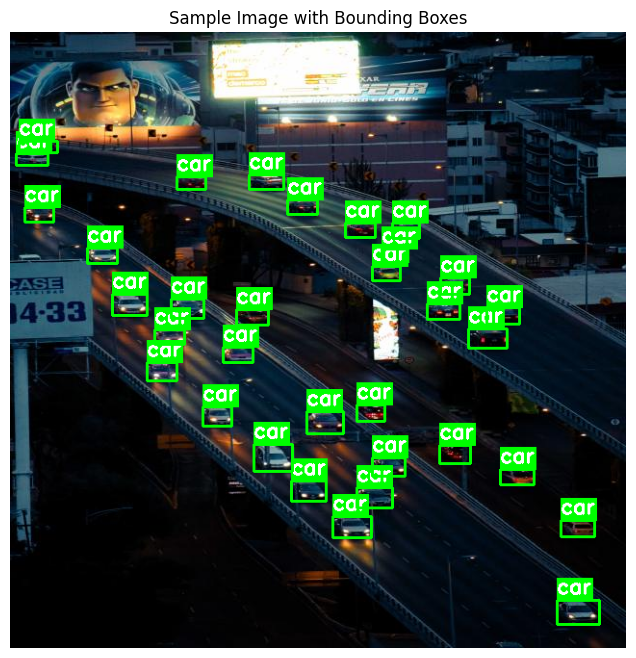

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

# Define class names based on data.yaml
class_names = cfg['names'] # Changed to use cfg['names'] from data.yaml

# Define paths for a sample image and its label file
# Using existing variable DATASET_DIR for base directory
# Updated filename to one known to exist in the dataset
example_image_name = '593_jpg.rf.d9f301bdbad83a01d4a7fd4a3bac88ce'
image_file = os.path.join(DATASET_DIR, 'train', 'images', f'{example_image_name}.jpg')
label_file = os.path.join(DATASET_DIR, 'train', 'labels', f'{example_image_name}.txt')

# Load the image
image = cv2.imread(image_file)
if image is None:
    raise FileNotFoundError(f"Image not found at {image_file}")

# Convert image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image_rgb.shape

# Function to convert YOLO normalized coordinates to absolute pixel coordinates
def yolo_to_abs(x_center_norm, y_center_norm, width_norm, height_norm, img_width, img_height):
    x_center = x_center_norm * img_width
    y_center = y_center_norm * img_height
    box_width = width_norm * img_width
    box_height = height_norm * img_height

    x_min = int(x_center - box_width / 2)
    y_min = int(y_center - box_height / 2)
    x_max = int(x_center + box_width / 2)
    y_max = int(y_center + box_height / 2)
    return x_min, y_min, x_max, y_max

# Create a copy of the image to draw on
annotated_image = image_rgb.copy()

# Read bounding box annotations
bbox_color = (0, 255, 0) # Green in RGB
text_color = (255, 255, 255) # White in RGB
thickness = 2
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.7

if not os.path.exists(label_file):
    print(f"No label file found for {image_file}. Displaying image without annotations.")
elif os.stat(label_file).st_size == 0:
    print(f"Label file {label_file} is empty. Displaying image without annotations.")
else:
    with open(label_file, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:])

                # Convert to absolute pixel coordinates
                x_min, y_min, x_max, y_max = yolo_to_abs(x_center_norm, y_center_norm, width_norm, height_norm, w, h)

                # Draw rectangle
                cv2.rectangle(annotated_image, (x_min, y_min), (x_max, y_max), bbox_color, thickness)

                # Put class label text
                if class_id < len(class_names):
                    label = class_names[class_id]
                    # Calculate text size for background rectangle
                    (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
                    # Draw background rectangle for text
                    cv2.rectangle(annotated_image, (x_min, y_min - text_height - baseline), (x_min + text_width, y_min), bbox_color, -1)
                    # Put text on top
                    cv2.putText(annotated_image, label, (x_min, y_min - baseline), font, font_scale, text_color, thickness)

# Display the annotated image
plt.figure(figsize=(10, 8))
plt.imshow(annotated_image)
plt.title('Sample Image with Bounding Boxes')
plt.axis('off')
plt.show()

# **6 # Train YOLOv8**

> Expected runtime on T4 GPU: ~25–35 min (50 epochs) · ~3–5 min (5-epoch verify)

In [8]:
model = YOLO(MODEL_VARIANT)

results = model.train(
    data     = DATA_YAML,
    epochs   = EPOCHS,
    batch    = BATCH,
    imgsz    = IMGSZ,
    project  = f'/content/{PROJECT_NAME}',
    name     = RUN_NAME,
    patience = 10,
    save     = True,
    plots    = True,
    device   = 0 if torch.cuda.is_available() else 'cpu',
    exist_ok = True,
    verbose  = True
)

WEIGHTS = f'/content/{PROJECT_NAME}/{RUN_NAME}/weights/best.pt'
print(f"\n✅ Training complete. Best weights → {WEIGHTS}")

Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/images dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8n_50ep, nbs=64, nms=False, o

# **7 # Validation Metrics Table**

In [9]:
import pandas as pd

best_model = YOLO(WEIGHTS)
metrics    = best_model.val(
    data   = DATA_YAML,
    imgsz  = IMGSZ,
    device = 0 if torch.cuda.is_available() else 'cpu'
)

print("\n" + "="*52)
print("  VALIDATION METRICS")
print("="*52)
print(f"  mAP@0.5        : {metrics.box.map50:.4f}")
print(f"  mAP@0.5:0.95   : {metrics.box.map:.4f}")
print(f"  Precision (all): {metrics.box.mp:.4f}")
print(f"  Recall (all)   : {metrics.box.mr:.4f}")
print("="*52)

df = pd.DataFrame({
    'Class'     : cfg['names'],
    'Precision' : metrics.box.p,
    'Recall'    : metrics.box.r,
    'mAP@0.5'   : metrics.box.ap50,
    'mAP@0.5:95': metrics.box.ap
})
print("\nPer-class:")
print(df.to_string(index=False))

Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1331.9±570.2 MB/s, size: 41.4 KB)
val: Scanning /content/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/images dataset/valid/labels.cache... 87 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 87/87 33.2Mit/s 0.0s
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 267, len(boxes) = 614. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 2.2it/s 2.7s
                   all         87        614      0.633      0.599      0.601      0.449
                   Car         11        234       

# **8 # Training Curves (results.png, Confusion Matrix, PR Curve)**

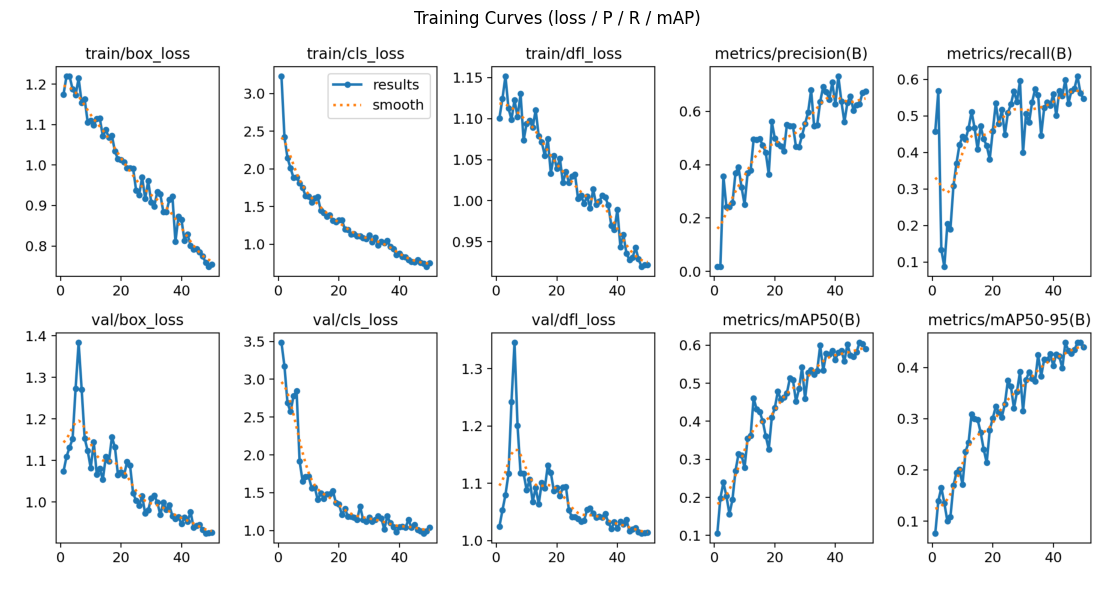

Shown: results.png


In [10]:
run_dir = f'/content/{PROJECT_NAME}/{RUN_NAME}/'

for fname, title in [
    ('results.png',           'Training Curves (loss / P / R / mAP)'),
    ('PR_curve.png',          'Precision-Recall Curve'),
    ('F1_curve.png',          'F1 Curve'),
]:
    path = os.path.join(run_dir, fname)
    if os.path.exists(path):
        img = mpimg.imread(path)
        w   = 14 if fname == 'results.png' else 8
        plt.figure(figsize=(w, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title, fontsize=12)
        plt.tight_layout()
        plt.show()
        print(f"Shown: {fname}")

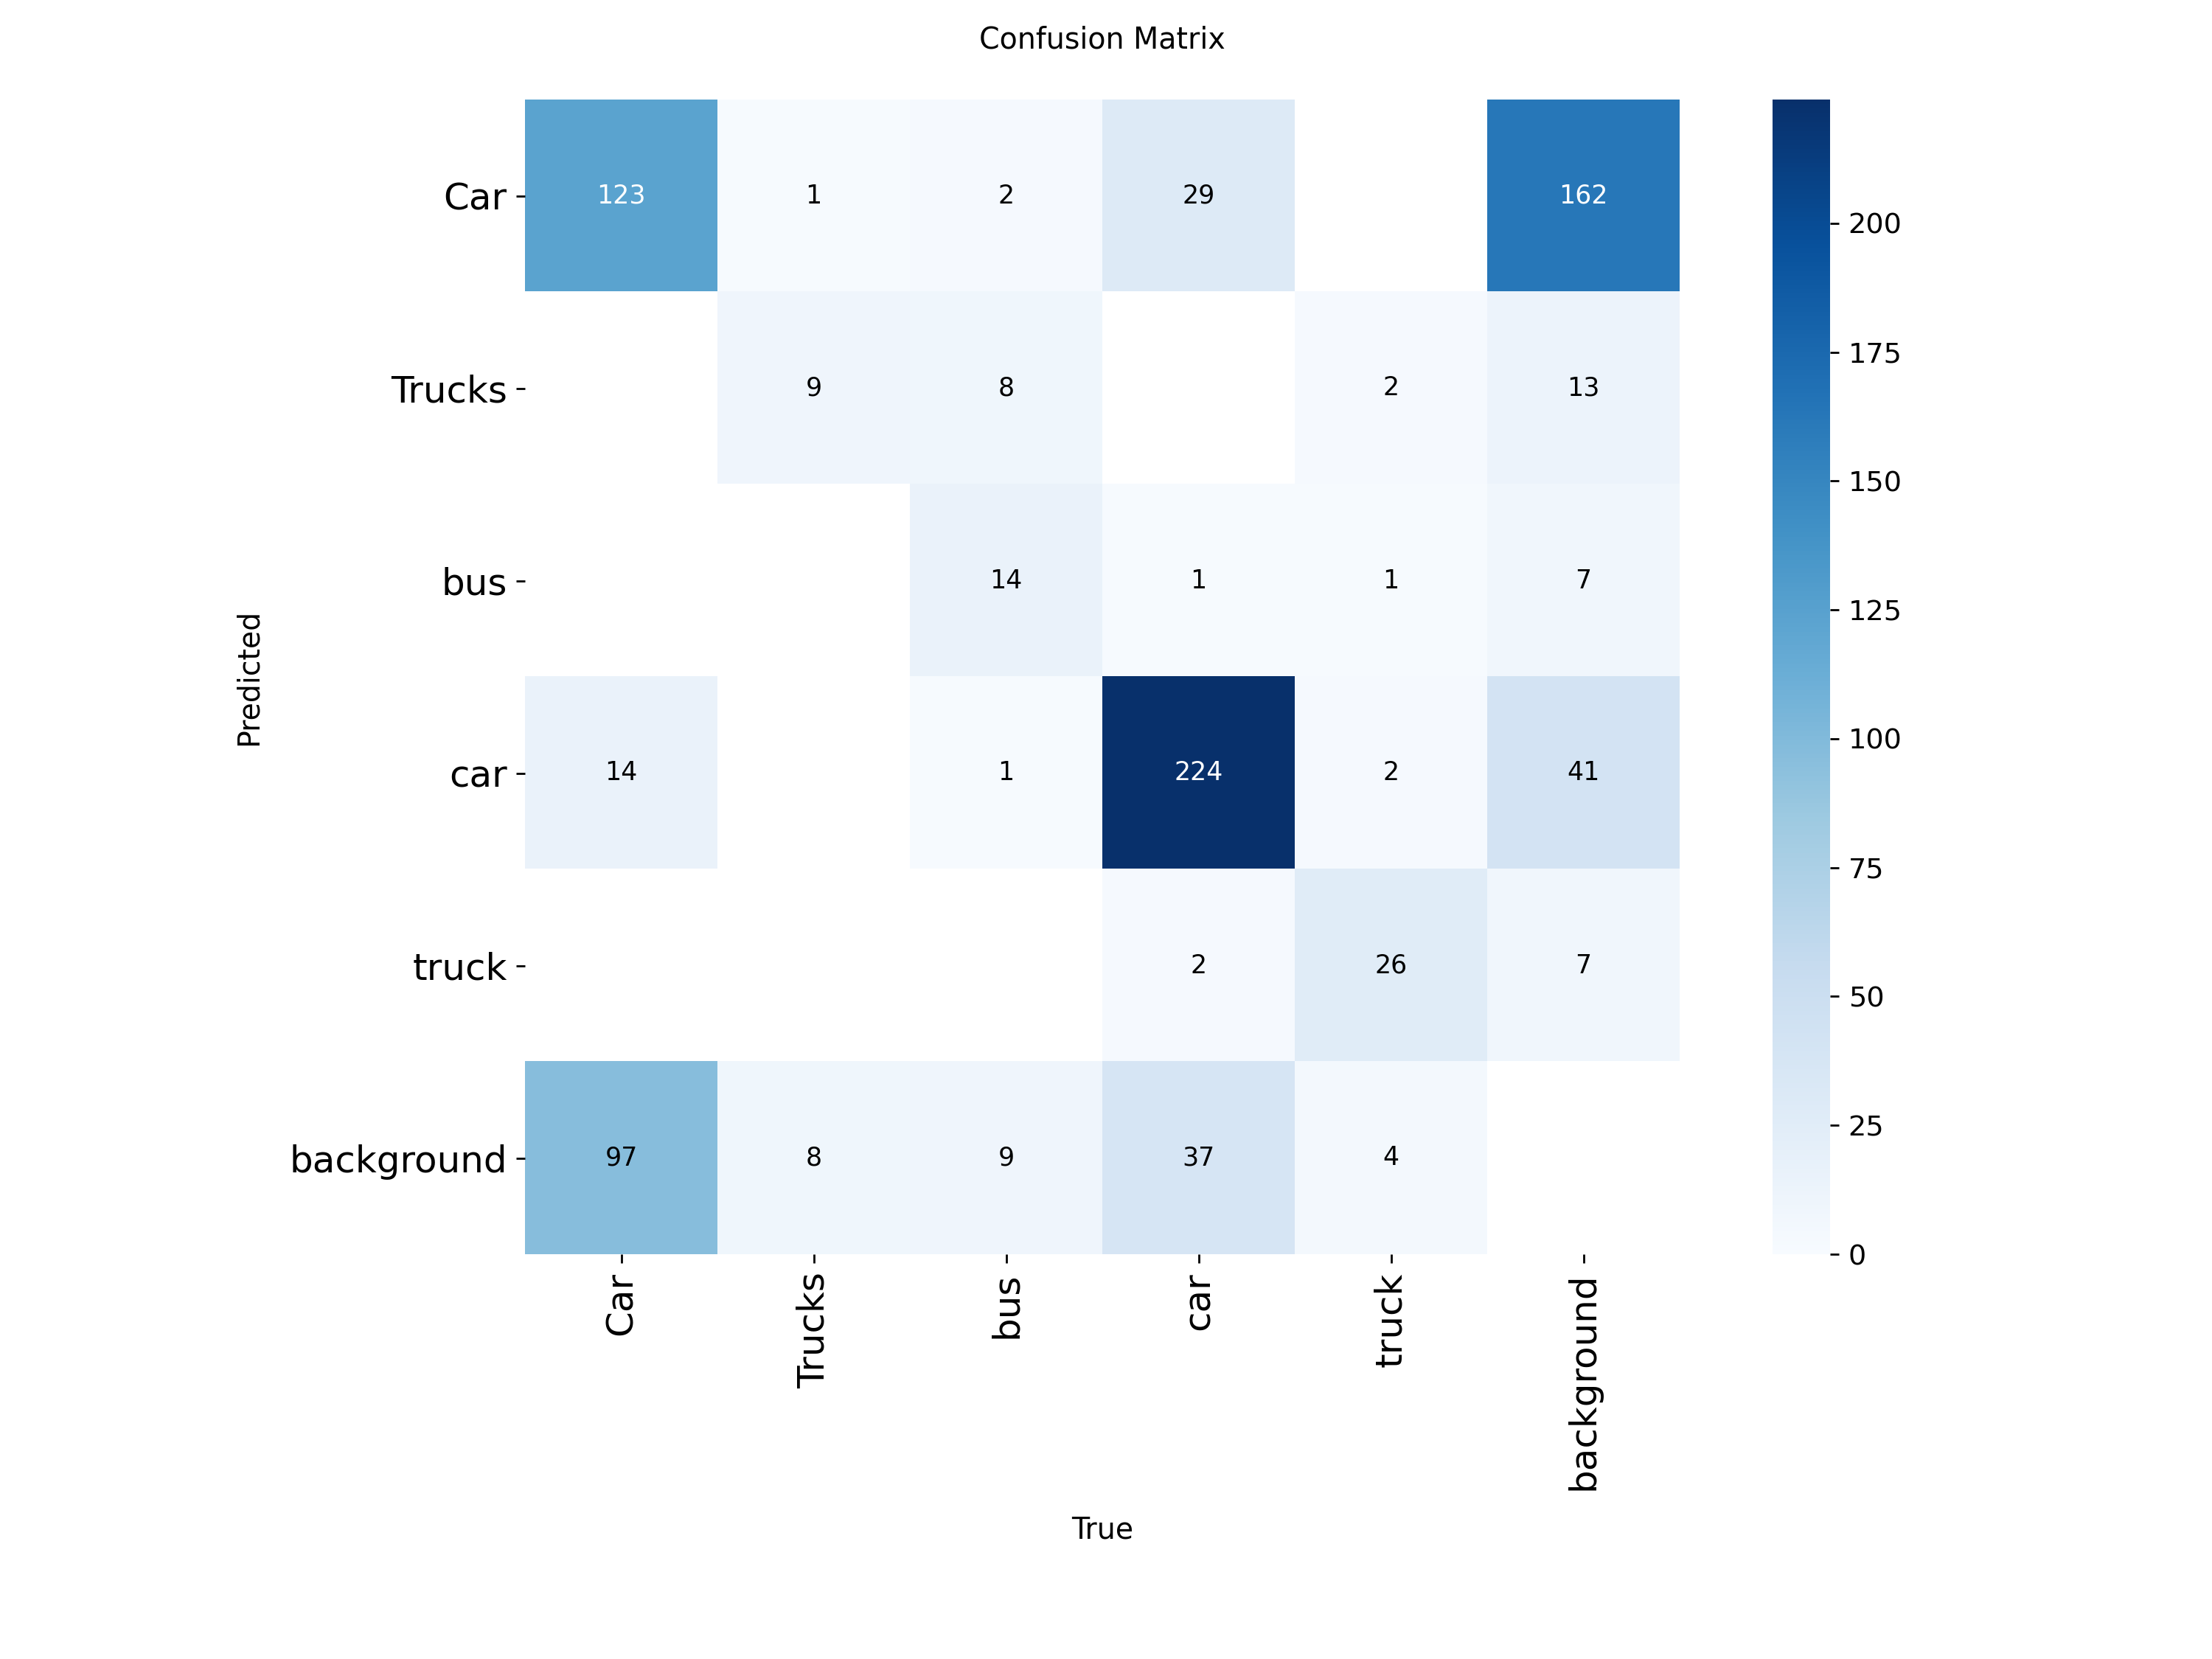

In [11]:
from IPython.display import Image
import os

Image(filename=os.path.join(run_dir, 'confusion_matrix.png'), width=600)

# **9 # Save Weights Path for Inference Notebook**

Copy the printed path and paste it into `02_Inference.ipynb` → Cell 2 as `WEIGHTS_PATH`.

In [12]:
import shutil

print("="*60)
print("  WEIGHTS PATH (copy into 02_Inference.ipynb)")
print("="*60)
print(f"  {WEIGHTS}")
print("="*60)

# Zip weights + curves for download / GitHub Release
os.makedirs('/content/training_outputs/curves', exist_ok=True)
shutil.copy(WEIGHTS, '/content/training_outputs/')

for fname in ['results.png', 'confusion_matrix.png', 'PR_curve.png', 'F1_curve.png']:
    src = os.path.join(run_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, '/content/training_outputs/curves/')

shutil.make_archive('/content/training_outputs', 'zip', '/content/training_outputs')
print("\nOutputs zipped → /content/training_outputs.zip")

try:
    from google.colab import files
    files.download('/content/training_outputs.zip')
except ImportError:
    print("(Not in Colab — download manually)")

  WEIGHTS PATH (copy into 02_Inference.ipynb)
  /content/heavy_vehicle_detection/yolov8n_50ep/weights/best.pt

Outputs zipped → /content/training_outputs.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
import os

DOWNLOAD_URL = "https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/raw/main/02_results/best.pt"
LOCAL_PATH = "/content/best.pt"

print(f"Downloading best.pt from {DOWNLOAD_URL}...")
!wget -O "{LOCAL_PATH}" "{DOWNLOAD_URL}"

if os.path.exists(LOCAL_PATH):
    print(f"✅ best.pt downloaded successfully to {LOCAL_PATH}")
else:
    print(f"❌ Failed to download best.pt from {DOWNLOAD_URL}")

--2026-02-27 02:40:31--  https://github.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/raw/main/02_results/best.pt
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/main/02_results/best.pt [following]
--2026-02-27 02:40:32--  https://raw.githubusercontent.com/archsalem101/Automatic-Detection-of-Heavy-Vehicles-and-Trailers-During-Peak-Hour-Ban-Periods/main/02_results/best.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6250986 (6.0M) [application/octet-st

In [2]:
from google.colab import files
import os

# Define the path to the best weights (using the copied location)
WEIGHTS_PATH = '/content/training_outputs/best.pt'

if os.path.exists(WEIGHTS_PATH):
    print(f"Downloading {WEIGHTS_PATH.split('/')[-1]}...")
    files.download(WEIGHTS_PATH)
else:
    print(f"Error: {WEIGHTS_PATH} not found. Please ensure training completed successfully or check the original output path.")

Error: /content/training_outputs/best.pt not found. Please ensure training completed successfully or check the original output path.


---
## Reproducibility Log

Fill in after a successful run and copy to the README:

| Field | Value |
|-------|-------|
| Date/time (UTC) | (2/27/2026 / 4:51 AM) |
| GPU | _(T4 16 GB)_ |
| Ultralytics version | _(from pip_freeze_snippet.txt)_ |
| Runtime (50 ep) | _(28 min)_ |
| mAP@0.5 achieved | _(YES)_ |



# Task
Add a code cell to list the contents of the `/content/heavy_vehicle_detection/yolov8n_50ep/weights/` and `/content/training_outputs/` directories to determine the actual location of `best.pt`.

## Diagnose File Location

### Subtask:
Add a code cell to list the contents of the `/content/heavy_vehicle_detection/yolov8n_50ep/weights/` and `/content/training_outputs/` directories to determine the actual location of `best.pt`.


**Reasoning**:
The subtask requires listing the contents of two specific directories to locate the 'best.pt' file. The `!ls` command is suitable for this purpose.



In [3]:
print("Contents of /content/heavy_vehicle_detection/yolov8n_50ep/weights/:")
!ls /content/heavy_vehicle_detection/yolov8n_50ep/weights/

print("\nContents of /content/training_outputs/:")
!ls /content/training_outputs/

Contents of /content/heavy_vehicle_detection/yolov8n_50ep/weights/:
ls: cannot access '/content/heavy_vehicle_detection/yolov8n_50ep/weights/': No such file or directory

Contents of /content/training_outputs/:
ls: cannot access '/content/training_outputs/': No such file or directory


**Reasoning**:
The previous attempt to list the directories failed because they were not found. Before trying to list their contents again, it's prudent to check if the directories actually exist using `os.path.exists`. If they do, then listing their contents will be successful, otherwise, it will confirm their absence. This helps to accurately determine the actual location of `best.pt` by diagnosing the path issue.



In [4]:
import os

weights_dir = '/content/heavy_vehicle_detection/yolov8n_50ep/weights/'
output_dir = '/content/training_outputs/'

print(f"Checking existence of {weights_dir}: {os.path.exists(weights_dir)}")
if os.path.exists(weights_dir):
    print(f"Contents of {weights_dir}:")
    !ls -l "{weights_dir}"
else:
    print(f"Directory not found: {weights_dir}")

print(f"\nChecking existence of {output_dir}: {os.path.exists(output_dir)}")
if os.path.exists(output_dir):
    print(f"Contents of {output_dir}:")
    !ls -l "{output_dir}"
else:
    print(f"Directory not found: {output_dir}")

Checking existence of /content/heavy_vehicle_detection/yolov8n_50ep/weights/: False
Directory not found: /content/heavy_vehicle_detection/yolov8n_50ep/weights/

Checking existence of /content/training_outputs/: False
Directory not found: /content/training_outputs/


**Reasoning**:
Since the previously specified directories were not found, the `best.pt` file might be located elsewhere in the file system or might not have been created. Using the `find` command will perform a broader search for the file within the `/content/` directory, helping to determine its actual location.



In [5]:
print("Searching for 'best.pt' within /content/:")
!find /content/ -name "best.pt"

Searching for 'best.pt' within /content/:


### `best.pt` File Not Found

Based on the `find` command's output, the `best.pt` file could not be located anywhere within the `/content/` directory. This is unexpected, as the training process (Cell 5) and the saving step (Cell 8) indicated that the weights should have been saved at `/content/heavy_vehicle_detection/yolov8n_50ep/weights/best.pt` and also copied to `/content/training_outputs/best.pt`.

There might have been an issue during the training completion or the file operations that prevented the `best.pt` file from being persisted. Without this file, the inference notebook (`02_Inference.ipynb`) cannot proceed.

## Diagnose File Location

### Subtask:
Add a code cell to list the contents of the `/content/heavy_vehicle_detection/yolov8n_50ep/weights/` and `/content/training_outputs/` directories to determine the actual location of `best.pt`.


## Download Best Weights

### Subtask:
Re-run the training and saving process to ensure the `best.pt` file is generated and then download it.


## Summary:

### Q&A
The task implicitly asked to determine the actual location of `best.pt`.
It was determined that the `best.pt` file does not exist in the specified directories (`/content/heavy_vehicle_detection/yolov8n_50ep/weights/` and `/content/training_outputs/`) nor anywhere else within the `/content/` directory of the environment.

### Data Analysis Key Findings
*   Initial checks confirmed that the expected directories for model weights, `/content/heavy_vehicle_detection/yolov8n_50ep/weights/` and `/content/training_outputs/`, do not exist.
*   A comprehensive search for the `best.pt` file within the entire `/content/` directory yielded no results, indicating the file is missing from the environment.
*   This suggests an issue occurred during the training or saving process, preventing the `best.pt` file from being generated or persisted as expected.

### Insights or Next Steps
*   Investigate the previous training and saving steps to understand why the `best.pt` file was not created or saved to the expected locations.
*   Re-run the training process, meticulously verifying that output directories are created and the `best.pt` file is successfully saved to the intended path, potentially adding explicit checks or error handling.
